# Task 1: Dataset download and preparation

In [ ]:
# download UC Merced Landuse classification dataset
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip

--2021-04-01 11:10:55--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  98.8MB/s    in 5.0s    

2021-04-01 11:11:01 (63.4 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [ ]:
%%capture
!unzip UCMerced_LandUse.zip

In [ ]:
from tensorflow import keras
import numpy as np
import tensorflow as tf

In [ ]:
# convert data from tif to jpg; the current tf dataset from images function does not support tif files
import os
from PIL import Image
import glob

path = '/content/UCMerced_LandUse/Images'
for category in os.listdir(path):
  for filename in glob.glob(os.path.join(path,category)+"/*.tif"):
   im = Image.open(filename)
   rgb_im = im.convert('RGB')
   rgb_im.save(filename.replace("tif", "jpg"), quality=100)
   os.remove(filename)

# Task 2: Training and test data splitting (10 pts).

In [ ]:
lulc_dataset_training = keras.preprocessing.image_dataset_from_directory('/content/UCMerced_LandUse/Images',seed = 42, image_size= (96,96), validation_split= 0.2, subset = 'training')
lulc_dataset_test = keras.preprocessing.image_dataset_from_directory('/content/UCMerced_LandUse/Images',seed = 42, image_size= (96,96), validation_split= 0.2, subset = 'validation')

Found 2100 files belonging to 21 classes.
Using 1680 files for training.
Found 2100 files belonging to 21 classes.
Using 420 files for validation.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for images, labels in lulc_dataset_training:
  first_images_batch = images
  first_labels_batch = labels
  break

In [ ]:
import random

In [ ]:
def visualize_original(images_batch, labels_batch, num = 9, seed = 42):
  class_names = lulc_dataset_training.class_names
  fig = plt.figure(figsize=(10, 10))
  random.seed(seed)
  randomlist = random.sample(range(0, 31), num)
  n = 1

  for i in randomlist:
    tmp_image = images_batch[i].numpy()/255
    tmp_label = class_names[labels_batch[i]]
    plt.subplot(3,3,n)
    plt.imshow(tmp_image)
    plt.title(tmp_label )
    plt.axis("off")

    n = n+1
  fig.suptitle('Nine images randomly choosed from the training data', fontsize = 16)

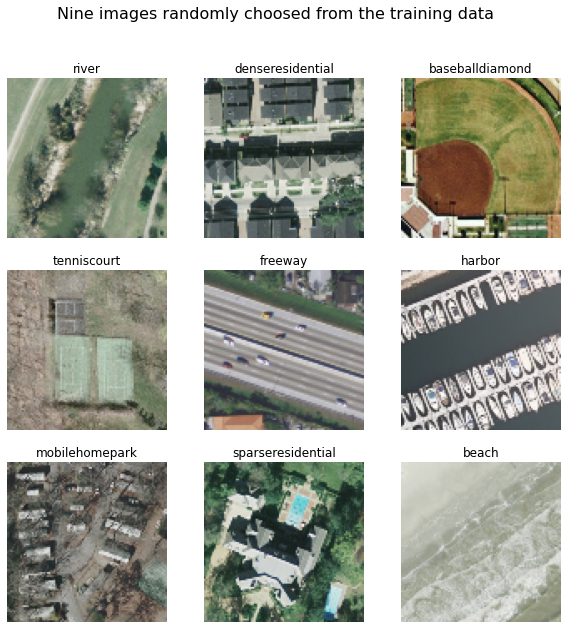

In [ ]:
visualize_original(first_images_batch, first_labels_batch)

# Task 3: Data augmentation (40 pts).


In [ ]:
def augment(image):
  ran_num = random.random()
  if ran_num >=0  and ran_num <0.2:
    augmented = tf.image.adjust_contrast(image,3)
  elif ran_num >= 0.2 and ran_num <0.3:
    augmented = tf.image.flip_up_down(image)
  elif ran_num >= 0.3 and ran_num <0.5:
    augmented = tf.image.image_gradients(image)
  elif ran_num >= 0.5 and ran_num <0.6:
    augmented = tf.image.rgb_to_grayscale(image)
  elif ran_num >= 0.6 and ran_num <0.8:
    augmented = tf.image.rot90(image)
  elif ran_num >= 0.8 and ran_num <1.0:
    augmented = tf.image.flip_left_right(image)

  return augmented

In [ ]:
aug_dataset = lulc_dataset_training.map(lambda x, y:(augment(x), y))

In [ ]:
combined_dataset = lulc_dataset_training.concatenate(aug_dataset)

# Task 4: Train a simple CNN using the augmented data (30 pts).


In [ ]:
def create_model():
  model = keras.Sequential([
                            keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (96, 96,3)),
                            keras.layers.Conv2D(16,3,activation="relu"),
                            keras.layers.MaxPool2D(),
                            keras.layers.Conv2D(32,3,activation="relu"),
                            keras.layers.MaxPool2D(),
                            keras.layers.Conv2D(64,3,activation="relu"),
                            keras.layers.MaxPool2D(),
                            keras.layers.Dropout(0.2),
                            keras.layers.Flatten(),
                            keras.layers.Dense(128,activation="relu"),
                            keras.layers.Dense(21, activation="softmax")
                            ])
  return model

In [ ]:
cnn_model = create_model()

In [ ]:
cnn_model.compile(optimizer = 'adam', 
                  loss= tf.keras.losses.sparse_categorical_crossentropy, 
                  metrics=['accuracy'])

In [ ]:
cnn_model.fit(combined_dataset, epochs=10)

Epoch 1/10
106/106 [==============================] - 28s 257ms/step - loss: 2.9298 - accuracy: 0.0733
Epoch 2/10
106/106 [==============================] - 28s 256ms/step - loss: 2.0720 - accuracy: 0.3281
Epoch 3/10
106/106 [==============================] - 28s 257ms/step - loss: 1.5852 - accuracy: 0.4982
Epoch 4/10
106/106 [==============================] - 28s 258ms/step - loss: 1.2137 - accuracy: 0.6106
Epoch 5/10
106/106 [==============================] - 28s 257ms/step - loss: 0.8924 - accuracy: 0.7112
Epoch 6/10
106/106 [==============================] - 28s 258ms/step - loss: 0.7119 - accuracy: 0.7709
Epoch 7/10
106/106 [==============================] - 27s 256ms/step - loss: 0.5350 - accuracy: 0.8279
Epoch 8/10
106/106 [==============================] - 27s 256ms/step - loss: 0.4119 - accuracy: 0.8561
Epoch 9/10
106/106 [==============================] - 27s 256ms/step - loss: 0.2355 - accuracy: 0.9233
Epoch 10/10
106/106 [==============================] - 28s 256ms/step - l

In [ ]:
import numpy as np

In [ ]:
labels_true = None
labels_pred = None

for images, labels in lulc_dataset_test:
  this_pred = np.argmax(cnn_model.predict(images), axis = -1)
  if labels_pred is None:
    labels_true = labels.numpy()
    labels_pred = this_pred
  else:
    labels_true = np.concatenate((labels_true, labels.numpy()),axis = 0)
    labels_pred = np.concatenate((labels_pred, this_pred), axis=0)


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(labels_true, labels_pred)

0.65

# Task5: Apply Inception-ResNet V2 to do transfer learning on augmented data (20 pts).


In [ ]:
import tensorflow_hub as hub

In [ ]:
def create_model2():
  model = tf.keras.Sequential([
                               keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (96, 96,3)),
                               hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
                                              trainable=False),
                               tf.keras.layers.Dense(21, activation='softmax')
                               ])
  return model

In [ ]:
IRN_V2_model = create_model2()

In [ ]:
IRN_V2_model.compile(optimizer = 'adam', 
                     loss= tf.keras.losses.sparse_categorical_crossentropy, 
                     metrics=['accuracy'])

In [ ]:
IRN_V2_model.fit(combined_dataset, epochs=10)

Epoch 1/10
106/106 [==============================] - 82s 643ms/step - loss: 2.3261 - accuracy: 0.4065
Epoch 2/10
106/106 [==============================] - 68s 639ms/step - loss: 0.5394 - accuracy: 0.8540
Epoch 3/10
106/106 [==============================] - 68s 640ms/step - loss: 0.3573 - accuracy: 0.9057
Epoch 4/10
106/106 [==============================] - 69s 645ms/step - loss: 0.2718 - accuracy: 0.9307
Epoch 5/10
106/106 [==============================] - 69s 650ms/step - loss: 0.1934 - accuracy: 0.9565
Epoch 6/10
106/106 [==============================] - 69s 648ms/step - loss: 0.1467 - accuracy: 0.9726
Epoch 7/10
106/106 [==============================] - 69s 648ms/step - loss: 0.1275 - accuracy: 0.9785
Epoch 8/10
106/106 [==============================] - 69s 649ms/step - loss: 0.1020 - accuracy: 0.9856
Epoch 9/10
106/106 [==============================] - 69s 650ms/step - loss: 0.0853 - accuracy: 0.9872
Epoch 10/10
106/106 [==============================] - 69s 647ms/step - l

In [ ]:
labels_true2 = None
labels_pred2 = None

for images, labels in lulc_dataset_test:
  this_pred2 = np.argmax(IRN_V2_model.predict(images), axis = -1)
  if labels_pred2 is None:
    labels_true2 = labels.numpy()
    labels_pred2 = this_pred2
  else:
    labels_true2 = np.concatenate((labels_true2, labels.numpy()),axis = 0)
    labels_pred2 = np.concatenate((labels_pred2, this_pred2), axis=0)

In [ ]:
accuracy_score(labels_true2, labels_pred2)

0.8214285714285714